\author{William~Trigos,~UIS}

In [ ]:
from sympy import *
%matplotlib inline
init_printing(use_latex=True)

\begin{abstract}
Se describe el planteamiento de un algoritmo de posicionamiento cooperativo en condiciones estáticas, en el que se tiene como hipotesis que que el intercambio de observables GPS entre dispositivos de frecuencia sencilla (single-frequency), permite mejorar el nivel de precisión en posicionamiento de los dispositivos. 

El algoritmo presentado utiliza la solución de posicionamiento autónomo de cada dispositivo en interacción, para recalcular la solución de posicionamiento empleando la información de satélites visibles en común. El planteamiento se apoya en la técnica de mínimos cuadrados ponderada (WLS), la cual tiene en cuenta la relación de distancia geométrica para establecer posicionamiento diferencial entre duplas de receptores que conforman la agrupación. 

Se plantean escenarios para evaluar la incidencia de la corrección ionosférica y sencibilidad en el observable de distancia entre duplas, para evaluar su impacto en la solución obtenida por el algoritmo.

Los resultados evidencian que es posible mejorar la precisión en dispositivos de single-frequency, tan solo empleando los raw-observables y la solución autónoma inicial obtenida por los dispositivos.
\end{abstract}

\keywords{Cooperative positioning, weight least squares, single frequency gps
receivers.}

# Introducción

Con el auge de Software-Defined-Radio (SDR) el desarrollo de dispositivos electrónicos apoyados en tareas de software ha aumentado significativamente en los últimos años. Gracias a SDR es posible contar con dispositivos fácilmente configurables y de bajo coste. Para el caso concreto de los paquetes de procesamiento GPS, como son GPSTk y RTKLib; es posible interpretar y procesar de ficheros RINEX, mediante rutinas de software específicas, que facilitan el estudio y desarrollo de nuevos algoritmos de posicionamiento.\newline

De esta forma, se consideró emplear el paquete GPSTk y su interfaz con lenguaje python para el desarrollo del presente estudio. Permitiendo centrar nuestros esfuerzos en el estudio y planteamiento del algoritmo cooperativo.\newline

El algoritmo cooperativo planteado, trabaja de forma secuencial para recalcular la posición de cada uno de los receptores que intercambia información. Sin embargo, cada receptor está en capacidad de ejecutar el algoritmo por sí mismo.

# Posicionamiento satelital

En esta sección se introducen un conjunto de conceptos relacionados con el problema de posicionamiento basado en sistemas de posicionamiento satelital, con el propósito
de tener un marco de referencia común para el lector, a partir del cual se desglosa el planteamiento de la idea y el desarrollo propuesto en este trabajo.


## Sistema global de posicionamiento satelital

La idea detrás de los sistemas de posicionamiento tales como GPS, puede ser resumida en:\newline

\textit{Si la distancia desde tres satélites en el espacio hasta un punto en común sobre la superficie de la tierra (un receptor GPS) es conocida, junto con la posición de los satélites al momento de la transmisión, la posición del receptor puede ser determinada gracias a la aplicación de conceptos trigonométricos, álgebra y un sistema de coordenadas apropiado \cite{Thompson_1998}}.\newline

La situación problema detrás de los sistemas de posicionamiento es ¿Cómo conseguir las distancias a cada satélite de forma precisa?; esto con el propósito de poder determinar la posición del receptor sobre la superficie de la tierra, lo mas exacto posible. Para tal fin, los modelos observacionales sirven como herramienta para describir los fenomenos fisicos involucrados en el viaje de la señal, de forma que se pueda representar la distancia entre el satélite y el receptor en función de los ciclos de la señal o la diferencia de tiempos desde el envio hasta la recepción de la señal.

## El pseudorango y su definición

Los sistemas de posicionamiento satelital funcionan gracias a la transmisión continua de señales de radiofrecuencia a través de la ionósfera y la tropósfera. En el caso específico de GPS, las señales transmitidas están conformadas por dos señales de portadora, dos códigos y un mensaje de navegación. Dichas señales son adquiridas por medio de una antena capas de percibir el rango de frecuencias en que transmiten los satélites es 1227.60 MHz y 1575.42 MHz.\newline

Los observables de medición arrojados por los dispositivos de posicionamiento, son el resultado del procedimiento interno de la señal en el receptor el cual esta en capacidad de estimar el tiempo de viaje de la señal. Los observables entregados por los dispositivos GPS, pueden ser de varios tipos y encapsulados en distintos formatos y/o estándares como es el caso de \textbf{NMEA\footnote{NMEA: National Marine Electronics Association,  http://www.gpsinformation.org/dale/nmea.htm}} y \textbf{RINEX\footnote{RINEX: Receiver INdependent EXchange, https://igscb.jpl.nasa.gov/igscb/data/format/rinex211.txt}}, entre otros.\newline

Para determinar la posición de un receptor, es necesario representar el lugar geométrico de los satelites tomando como referencia las coordenadas de los satélites y la distancia a la posición del receptor, para luego encontrar la intersección de los lugares geometrícos de los satelites; como se aprecia en la figura \ref{fig:Trilateracion}.

\begin{figure}[htp]
    \centering
    \includegraphics{Figs/Trilateracion.png}
    \caption{Figura \ref{fig:Trilateracion} Representación geométrica del concepto de trilateración.}
    \label{fig:Trilateracion}
\end{figure}

Para representar la distancia existente entre el satélite y el receptor, se emplean los modelos de observables. Un ejemplo podría ser el caso de la expresión \ref{modelo Observables}, en la cual se define el valor del observable como una multiplicación del tiempo de vuelo por la velocidad de la luz.

\begin{equation}
  P_{r}^{s} = TOF*c = (T_r - T_s)*c
  \label{modelo Observables}
\end{equation}

\noindent Donde:

\begin{itemize}
	\item $T_r$ es un tiempo conocido por el usuario al momento de la recepción. 
	\item $T_s$ el tiempo de envío de la señal desde el satélite, que puede ser obtenido a partir de un mensaje de navegación. 
	\item $c$ es el valor de la velocidad de la luz en el vacío.\newline 
\end{itemize}

Sin embargo, el modelo anterior es muy básico como para representar los distintos fenómenos que transcurren durante el viaje de la señal a traves de la atmosfera; fenomenos que afectan a la señal e impiden determinar la distancia entre el satélite y el receptor con exactitud.\newline

Algunos modelos de observables, se suelen representar los errores asociados con los orbitales de los satélites como una constante, tras considerar que el cambio instantáneo en la posición de los satélites es demasiado lenta con el tiempo de muestreo de las señales satelitales. De igual forma, el retraso ionosférico puede ser modelado por medio de constantes o funciones con tasas de cambio lentas, para representar la variación del contenido de electrones entre una medición y otra.\newline

Incluso esta última consideración, es una de las bases para planteamiento del posicionamiento diferencial, donde se plantea que el error ionosférico es similar entre receptores cercanos y mediciones consecutivas (época a época). Como es el caso del estudio en \cite{el1994effect}, \cite{blewitt1997basics}, en el cual se presenta que el retraso ionosférico para múltiples receptores ubicados relativamente cerca entre sí (rangos de 200 km), puede asumirse que el retraso ionosférico es similar entre los receptores.

## Técnicas de posicionamiento.

Aunque una buena parte de las técnicas de posicionamiento trata de acoger la mayor parte del modelo de pseudorango, no todas están en capacidad de modelar o compensar los efectos asociados a las fuentes de error.

### Diferencial.

También conocido como modelos de posicionamiento de línea de base (baseline). Es una técnica que consiste de referenciar un objeto con respecto a nodos perfectamente referenciados. Las técnicas diferenciales son muy comunes entre pares de receptores, cuando sus disntacias no superan los 200km entre si.\newline

\begin{figure}
    \centering
    \includegraphics{Figs/rango_satelites.pdf}
    \caption{Figura \ref{fig:2RX1sat} Diferenciamiento sencillo}
    \label{fig:2RX1sat}
\end{figure}

El modelo de diferenciamiento sencillo\ref{fig:2RX1sat}, comprende la operación de diferencia entre los observables de 2 receptores (Rx1, Rx2) durante una misma epoca (mismo tiempo) con respecto a un satélite en común. Considerando que el modelo de observable para el par de receptores es:

\begin{equation}
	\begin{aligned}
		P_{A}^{s}(t) = \rho_{A}^{s}(t) +c*\tau_{A}(t) - c*\tau^{s}(t) -d_{iono}^{s} + d_{trop}^{s} + \epsilon_{A}^{s}\\
		P_{B}^{s}(t) = \rho_{B}^{s}(t) +c*\tau_{B}(t) - c*\tau^{s}(t) -d_{iono}^{s} + d_{trop}^{s} + \epsilon_{B}^{s}
	\label{eq:Ec3}
	\end{aligned}
\end{equation}

Al aplicar la diferencia a los pseudorangos en un mismo instante de tiempo, se obtendrá que:

\begin{equation}
	\begin{aligned}
		\bigtriangleup P_{AB}^{s} 
		& = P_{B}^{s} - P_{A}^{s}\\
		& =(\rho_{B}^{s}-\rho_{A}^{s}) + c*(\tau_{B} - \tau_{A}) + (\epsilon_{B}^{s} - \epsilon_{A}^{s})\\
		& = \bigtriangleup \rho_{AB}^{s} + c*\bigtriangleup (\tau_{AB}) + \bigtriangleup(\epsilon_{AB}^{s})
	\label{eq:Ec4}
	\end{aligned}
\end{equation}\\

De forma que los términos $d_{iono}^{s}$ y $d_{trop}^{s}$, pueden asumirse similares para ambos receptores conforme a lo expuesto en los estudios \cite{el1994effect}, \cite{blewitt1997basics}; con lo cual las fuentes de error se anulan mutuamente.

Según Rhedgecock \cite{hedgecock2014precise}, la diferencia entre los rangos obtenidos por dos receptores a un mismo satélite en línea de vista, es equivalente a la proyección del vector distancia entre los receptores en la dirección del satélite. \newline

De forma que, al ser la distancia entre los receptores y el satélite muy grande comparada con la distancia entre ellos; la proyección del vector distancia puede ser asumida como igual para ambos receptores. 

\begin{figure}
    \centering
    \includegraphics{Figs/SD_Rhedgecock.png}
    \caption{Figura \ref{fig:SD_Rhedgecock} Geometric interpretation of the single-differencing operation from \cite{hedgecock2014precise}}
    \label{fig:SD_Rhedgecock}
\end{figure}

Este planteamiento de Rhedgcock es útil para el planteamiento de cosenos directores asociados a la distancia entre duplas de receptores, que se presentará en la siguiente sección.

# El algortimo cooperativo

El planteamiento del algoritmo de posicionamiento cooperativo está apoyado en la técnica numérica de mínimos cuadrados ponderados WLS, de forma que la asociación
de la terminología y planteamiento pueden facilitar la comprensión de la técnica de posicionamiento propuesta en esta sección.

## Mínimos cuadrados

El planteamiento de mínimos cuadrados establece un proceso de linearización al modelo no lineal asociado al pseudorango existente entre un receptor GPS y un satélite visible
desde su ubicación, con lo cual, una observación GPS obtenida por el receptor puede ser considerada como:
    
\begin{equation}
\begin{aligned}
P_{obs} &= pseudorango_{modelo} + ruido \\
        &= P(x,y,z,\tau) + \eta
\end{aligned}
\end{equation}

Aplicar la expansión de series de taylor al modelo de pseudorango,
alrededor de un punto de operación $(x_o, y_o, z_o, \tau_o)$ e
ignorando los términos de orden superior y errores de truncamiento
asociados, el modelo de pseudorango sería definido como:

\begin{equation}
\begin{aligned}
P(x,y,z,\tau) &= P(x_o,y_o,z_o,\tau_o) 
                 +(x-x_o){\frac{\partial P}{\partial x}}
                 +(y-y_o){\frac{\partial P}{\partial y}}
                 +(z-z_o){\frac{\partial P}{\partial z}}
                 +(\tau-\tau _o){\frac{\partial P}{\partial \tau}} \\
        &= P(x_o,y_o,z_o,\tau_o) 
                 +{\frac{\partial P}{\partial x}} \Delta x 
                 +{\frac{\partial P}{\partial y}} \Delta y
                 +{\frac{\partial P}{\partial z}} \Delta z 
                 +{\frac{\partial P}{\partial \tau}}\Delta \tau  \\
\end{aligned}
\label{eq:partials1}
\end{equation}

Al plantear la diferencia (el error) entre los valores observados de distancia y el modelo linearizado de pseudorango, se obtiene una expresión:

\begin{equation}
\begin{aligned}
\Delta{P} &= (\frac{\partial P}{\partial x}, \frac{\partial P}{\partial y}, \frac{\partial P}{\partial t},\frac{\partial P}{\partial \tau})
            (\Delta{x} \Delta{y} \Delta{z} \Delta{\tau})^{T} \\
          &= H*\Delta{X} 
\end{aligned}
\label{eq:partials2}
\end{equation}

donde:

\begin{itemize}
\item $ \Delta P = P_{obs} - P(x_o,y_o,z_o,\tau_o)$
\item $H$ Matriz de cosenos directores
\item $ \Delta X = (\Delta x \Delta y \Delta z \Delta \tau)^{T}$
\end{itemize}

Para la cual, el método de mínimos cuadrados iterativamente calcula el valor del término $\Delta{P}$ de forma que se obtenga la mínima diferencia en $\Delta{X}$ que satisface la expresión:

\begin{equation}
\begin{aligned}
         \Delta{P} = min(\Delta{P} - H*\Delta{X}) 
\end{aligned}
\end{equation}


## Planteamiento de LS Cooperativo

El planteamiento para el algoritmo cooperativo parte de considerar la distancia entre dos receptores GPS como información útil para contribuir a la precisión en
posicionamiento de los receptores que integran el conjunto en interacción. La distancia entre los receptores es considerada como una variable de control, que puede ser obtenida con la ayuda de sensores de distancia ubicados en los receptores GPS o ser calculada a partir de las coordenadas obtenidas de la tarea de posicionamiento autónomo de cada receptor. \newline

La distancia estimada por cualquiera de estas dos alternativas conlleva un nivel de error asociado a su valor, por ende la propagación de su incertidumbre al
momento de ser empleada para calcular las posiciones de los receptores en el método cooperativo, es considerada como un objeto de estudio en el apartado experimental del proyecto. \newline

Adicionalmente se tienen las siguientes consideraciones:\newline

<div class="burk">
\begin{itemize}
    \item Que ${{e}_{A}^{AB}}$ ≠ ${{e}_{A}^{BA}}$ , no existe simetría en la solución de posicionamiento.
    \item Que la distancia entre una dupla de receptores ${d_{AB}}$ ≤ 1km.
    \item Que el número de ${n_{sats}}$ ≥ 4.
\end{itemize}
</div><i class="fa fa-lightbulb-o "></i>
donde:

\begin{itemize}
    \item ${d_{AB}}$ la distancia entre una dupla de receptores
    \item ${n_{sats}}$ es el número de satelites visibles en común para la agrupación de receptores.
    \item ${{e}_{A}^{AB}}$ es el error de posicionamiento del receptor A obtenido al ejecutar el algoritmo localmente (receptor A), tomando los observables del receptor B como información adicional.
    \item ${{e}_{A}^{BA}}$ es el error de posicionamiento del receptor A obtenido al ejecutar el algoritmo remotamente (receptor B)
\end{itemize}

<div class="burk">
Es importante hacer énfasis en el comportamiento asimétrico de la solución de posicionamiento obtenida mediante el algoritmo cooperativo propuesto; y el cual se
representa mediante la primera consideración. Para explicar este comportamiento, se debe considerar una dupla compuesta por un
receptor A (“principal”) y B (“remoto”). De forma que cuando el receptor “Principal” emplea el algoritmo cooperativo para obtener su posición, la información del receptor “remoto” es tomada como... FALTA COMPLEMENTAR LA IDEA.\newline


Este comportamiento puede estar asociado a que la calidad de los observables en uno de los receptores, es de mejor calidad, que en el otro receptor que conforma la dupla. De forma que, si ya que es un hallazgo producto del desarrollo del presente estudio.
</div><i class="fa fa-lightbulb-o "></i>

In [1]:
from sympy import *
%matplotlib inline
init_printing(use_latex=True)
%run -i ../code/WallasUtils.py
#%run -i ../code/utils.py
%run -i ../code/Wallas_symbolic_utils.py
%run -i ../code/multirover4.py

In [11]:
n_vars = 4
n_sats = 4
n, m = 2*n_sats+1, 2*n_vars#+3
# create a symbolic matrix for construct A matrix
A  = Matrix(MatrixSymbol("A",n, m))

Dist, Ad = create_distance_matrix("A", "B", "B")
Aa, Pa, Xa = create_matrix_x_receiver("A", n_sats=n_sats)
Ab, Pb, Xb = create_matrix_x_receiver("B", n_sats=n_sats)

Pma = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('A', i+1)))
Pda = Matrix(n_sats, 1, lambda i,j:var('\Delta{P_{%s}^{(%d)}}' % ('A', i+1)))
Pmb = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('B', i+1)))
Pdb = Matrix(n_sats, 1, lambda i,j:var('\Delta{P_{%s}^{(%d)}}' % ('B', i+1)))
Pmd = Matrix(1, 1, lambda i,j:var('d_{%s%s}' % ('A', 'B')))
Pdd = Matrix(1, 1, lambda i,j:var('\Delta{d_{%s%s}}' % ('A', 'B')))

Ps = Matrix(MatrixSymbol("P",n, 1))
Ps[:n_sats, :]   = Pma
Ps[n_sats:-1, :] = Pmb
Ps[-1] = Pmd
#Psd = Matrix(1, 1, lambda i,j:var('d_{%s%s}' % ('A', 'B')))

PD  = Matrix(MatrixSymbol("P",n, 1))
PD[:n_sats, :]   = Pda
PD[n_sats:-1, :] = Pdb
PD[-1] = Pdd

rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('A', i+1)))
rho_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('B', i+1)))

rho = Matrix(MatrixSymbol("P_comp",n, 1))
rho[:n_sats, :]   = rho_a
rho[n_sats:-1, :] = rho_b
rho[-1] = Matrix(1, 1, lambda i,j:var(' \hat{d_{%s%s}}' % ('A', 'B')))

# component asociated to position of local receiver
A[:n_sats,:n_vars:] = Aa
A[:n_sats,n_vars:] = np.zeros(np.shape(A[:n_sats,n_vars:]))

# component asociated to position of remote receiver
A[n_sats:-1,n_vars:] = Ab
A[n_sats:-1,:n_vars] = np.zeros(np.shape(A[n_sats:-1,:n_vars]))

# component asociated to distance between receivers
A[-1,:] = np.hstack((zeros(1,4), 2*Ad[:,:3], zeros(1,1)))

Pm = Matrix(MatrixSymbol("P_mod",n, 1))
Pm[:n_sats, :]   = Ps[:n_sats, :] - Pa
Pm[n_sats:-1, :] = Ps[n_sats:-1, :] - Pb
Pm[-1]           = Pmd[-1, :] - 2*Dist


Asym = A
bsym = Pm#rho

### El modelo de pseudorango asumido.

En cuanto al modelo de pseudorango $\rho_i$ considerado para el presente estudio, se considera que el modelo involucra la distancia geométrica hasta el satélite visible y el error de sincronización en el reloj del receptor $\tau_a$, los términos asociados a fenómenos ionosféricos, troposféricos y demás, son
agrupados como parte del término de error $\nu_i$. Para efectos demostrativos, en esta sección del documento se asume que $\nu_i=0$ para los receptores que conforman la pareja en posicionamiento cooperativo. \newline

Como caso concreto, los pseudorangos a cuatro satélites desde un receptor k serán:

In [13]:
# Paa = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('a', i+1)))
# Pab = Matrix(n_sats, 1, lambda i,j:var('P_{%s}^{(%d)}' % ('b', i+1)))

# rho_a = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('a', i+1)))
# rho_b = Matrix(n_sats, 1, lambda i,j:var('\hat{\\rho_{%s}^{(%d)}}' % ('b', i+1)))

nua    = Matrix(n_sats, 1, lambda i,j:var('{\\nu}_{A}^{%d}'%(i+1) ))
nub    = Matrix(n_sats, 1, lambda i,j:var('{\\nu}_{B}^{%d}'%(i+1) ))

Ecuacion(Eq(rho_a, Pa+nua))
#Ecuacion(Eq(rho_b, Pb+nub))

<IPython.core.display.Latex object>

### El observable de distancia.
Para efectos del planteamiento matemático, se considera que el error sobre este estimado de distancia es despreciable ($\epsilon_d=0$). De forma que la distancia estimada entre dos receptores $A(x_a, y_a, z_a)$ y $B(x_b, y_b, z_b)$ estará definida como:

\begin{equation}
\begin{aligned}
{d}_{AB} &= \sqrt{{\left(x_b - x_a\right)}^{2} + {\left(y_b - y_a\right)}^{2} + {\left(z_b - z_a\right)}^{2}}
\end{aligned}
\label{eq:d_est}
\end{equation}

La expresión \ref{eq:d_est} formará parte del vector de residuales empleado para el posicionamiento cooperativo.

### Matrix de cosenos directores
De forma similar al planteamiento de los vectores de residuales, se retoman las expresiones para los cosenos directores a cada uno de los satélites vistos en común por cada receptor de la dupla. Para efectos demostrativos, se considera que los receptores A y B tienen visibilidad a 4
Satélites en común, ubicados en posiciones $x_i, y_i, z_i$ (i=1..4). Para una cantidad de (k=2) receptores:

In [14]:
# https://tex.stackexchange.com/questions/161299/squares-in-matrix
def get_matrix_cosdir(rx_id = "a", n=4, m=4):

    simbolics = "x_%s y_%s z_%s \\tau_%s c"%(rx_id, rx_id, rx_id, rx_id)
    x,y,z,t,c = symbols(simbolics)
    X       = Matrix(m, 1, [x,y,z,t])
    A       = Matrix(n, X.shape[0], lambda i,j :var('\hat{H_{%s}^{%s}}' % (X[j], i)))
    #print type(A)
    A[:,3] = [1]*n #np.ones(4)
    #print type(A)
    if n>4:
        A[4:, 3:] = [0]*(n-4)

    return A, X

Ha, Xa = get_matrix_cosdir(rx_id="A")
Hb, Xb = get_matrix_cosdir(rx_id="B", n=5, m=4)
Hm, Xm = get_matrix_cosdir(rx_id="k", n=5, m=4)

# coseno director distancia
X = Matrix(4,1,symbols("x y z \\tau"))
Hd = Matrix(n_sats, 1, lambda i,j:var('\hat{d_{%s}^{%s}}' % ('AB', X[i]))).T
Hd[3] = 0
Hb[-1, :3] = Hd[-1, :3]

Hm, Xm = get_matrix_cosdir(rx_id="k", n=5, m=4)
Hdm = Matrix(n_sats, 1, lambda i,j:var('\hat{d_{%s}^{%s}}' % ('Ak', X[i]))).T
Hdm[3] = 0
Hm[-1, :3] = Hdm[-1, :3]

Ecuacion(Ha)
#Ecuacion(Hb[:-1,:])

<IPython.core.display.Latex object>

Donde

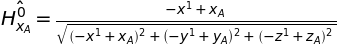

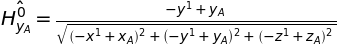

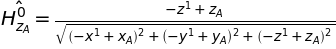

In [15]:
display(Eq(Ha[0,0], Aa[0,0])) 
display(Eq(Ha[0,1], Aa[0,1]))
display(Eq(Ha[0,2], Aa[0,2]))

Son las explresiones para las derivadas parciales del modelo de pseudorango con respecto al primer satelite en el receptor A, conforme al planteamiento presentado en las Ecuaciones  \ref{eq:partials1}, \ref{eq:partials2}. De manera similar, se calculan los cosenos directores para los demas satelites en común entre el receptor A y B.\newline

Hasta este punto, el planteamiento de las matrices de cosenos directores y el modelo de pseudorango es similar al que puede considerarse para la solución en posicionamiento autónomo, para cada receptor. \newline

Ahora el planteamiento para el algoritmo de posicionamiento cooperativo propuesto, toma en cuenta el planteamiento de \cite{hedgecock2014precise} y el observable de distancia planteado en la ecuación \ref{eq:d_est}, para modificar la estructura de la matriz de cosenos directores.

### Coseno director asociado a la distancia entre duplas receptores

Antes de proceder al planteamiento de la matriz de cosenos directores para el algoritmo cooperativo, es importante presentar el planteamiento detrás del observable de distancia entre una duplas de receptores, conformada por un receptor principal y uno o mas receptores remotos. \newline

Para efectos del planteamiento se considera que:
\begin{itemize}
    \item que la dupla cooperativa esta conformada por los receptores A y B
    \item que A es el receptor principal 
    \item que B es el receptor remoto 
\end{itemize}

Entonces, para la dupla conformada por A y B se tiene que la distancia entre los receptores obedece a la distancia geométrica planteada en la ecuación \ref{eq:d_est} y que, los respectivos cosenos directores en las direcciones "x, y, z" son:

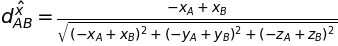

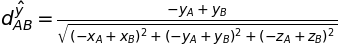

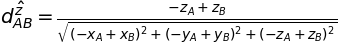

In [16]:
display(Eq(Hd[0,0], 2*Ad[0]))
display(Eq(Hd[0,1], 2*Ad[1]))
display(Eq(Hd[0,2], 2*Ad[2]))

Considerando que la posición de cualquier receptor que conforme una dupla, es calculada de forma iterativa por el algoritmo numérico que se emplee para dar al dar solución al sistema de ecuaciones planteado en la matriz de cosenos directores.\newline

Al incorportar la relación geométrica adicional que representa el efecto de ligadura entre el receptor principal y el remoto, por medio de un coseno director asociado a la distancia que los separa. De forma implícita, el algoritmo numérico está en capacidad de minimizar el error las coordenadas de
los receptores y a su vez minimizar el error en el estimado de la distancia que separa a los receptore que conforman la dupla.\newline

De forma que, la matriz de posicionamiento cooperativo tendrá el coseno director de distancia entre cada receptor remoto con respecto al receptor principal, considerando que las duplas cooperativas se conforman entre receptores que tienen satélites visible en común, lo cual permite que la información de observables del receptor remoto sea útil al receptor principal.

Con lo anterior, la expresión para las cosenos directores en el receptor remoto (B), serán:

In [17]:
Ecuacion(Hb)

<IPython.core.display.Latex object>

## La matriz de cosenos directores cooperativa

Tomando como punto de partida las matrices de coseno directores en cada uno de los receptores que conforman la agrupación, y anexando el planteamiento del coseno
director para las distancias en los receptores remotos, se tiene que:
    
* El número de filas de la matriz de cosenos directores cooperativa es:
$$Rows = n_{sats}*n_{rx} + (n_{rx} - 1))$$

Esto acorde a que los matrices de cosenos directores para los receptores remotos, tendrán siempre una fila adicional.

El número de columnas de la matriz de cosenos cooperativa es:
$$Cols = n_{vars}*n_{rx}$$

\begin{itemize}
    \item $n_{sats}$ es el número de satélites visibles en común para la agrupación de receptores.
    \item $n_{rx}$ es el número que componen la agrupación de receptores.
    \item $n_{vars}$ es número de variables $x, y, z, \tau$ a resolver en cada receptor en interacción para el cálculo de posicionamiento cooperativo.
\end{itemize}

Para efectos demostrativos considere el caso de tres receptores en interacción ($n_{rx} = 3$), y cuatro satelites en común ($n_{rx}$ = 4), con lo cual la matriz de cosenos directores cooperativa sería:

In [18]:
from sympy.matrices import diag, Matrix, ones
Ecuacion(Matrix(diag(Ha, Hb, Hm)))

<IPython.core.display.Latex object>

Una visión generalizada de la matriz de cosenos directores cooperativa, permite deducir que cualquier variación en las coordenadas estimadas para un receptor de la agrupación, se verá reflejada en la posición de sus semejantes a través del coseno director de distancia que este conforme con los demas receptores de la agrupación.\newline

### Vector de residuales. 
De manera análoga al planteamiento del posicionamiento autónomo, el vector de residuales ∆P contempla la agrupación de los vectores de residuales autónomos para cada uno de los receptores que conforman una dupla de receptores trabajando en ámbito cooperativo. (ej: receptores a y b, son una dupla cooperativa)

In [19]:
Eq(Pda, Pma - rho_a), Eq(Pdb, Pmb - rho_b)

⎛⎡\Delta{P_{A}__{(1)}}⎤   ⎡P_{A}__{(1)} - \hat{\rho_{A}__{(1)}}⎤  ⎡\Delta{P_{B
⎜⎢                    ⎥   ⎢                                    ⎥  ⎢           
⎜⎢\Delta{P_{A}__{(2)}}⎥   ⎢P_{A}__{(2)} - \hat{\rho_{A}__{(2)}}⎥  ⎢\Delta{P_{B
⎜⎢                    ⎥ = ⎢                                    ⎥, ⎢           
⎜⎢\Delta{P_{A}__{(3)}}⎥   ⎢P_{A}__{(3)} - \hat{\rho_{A}__{(3)}}⎥  ⎢\Delta{P_{B
⎜⎢                    ⎥   ⎢                                    ⎥  ⎢           
⎝⎣\Delta{P_{A}__{(4)}}⎦   ⎣P_{A}__{(4)} - \hat{\rho_{A}__{(4)}}⎦  ⎣\Delta{P_{B

}__{(1)}}⎤   ⎡P_{B}__{(1)} - \hat{\rho_{B}__{(1)}}⎤⎞
         ⎥   ⎢                                    ⎥⎟
}__{(2)}}⎥   ⎢P_{B}__{(2)} - \hat{\rho_{B}__{(2)}}⎥⎟
         ⎥ = ⎢                                    ⎥⎟
}__{(3)}}⎥   ⎢P_{B}__{(3)} - \hat{\rho_{B}__{(3)}}⎥⎟
         ⎥   ⎢                                    ⎥⎟
}__{(4)}}⎦   ⎣P_{B}__{(4)} - \hat{\rho_{B}__{(4)}}⎦⎠

Para el caso particular de posicionamiento cooperativo, se puede apreciar que:

In [20]:
Ecuacion(Eq(PD, bsym))

<IPython.core.display.Latex object>

Adicionalmente, el término asociado con el coseno director de la distancia entre los receptores que conforman una dupla cooperativa, forma parte del vector de residuales. Por ello por cada dupla de receptores que se conforma en el ámbito cooperativo, el vector de residuales tendrá una fila adicional en la cual se establece la diferencia entre el observable de distancia y su respectivo modelo algebraico.

## dimensiones y solución del minimos cuadrados

Si se considerará la solución de posicionamiento autonómo para el receptor $A$, este sistema de ecuaciones comprende un sistema de ecuaciones determinado para el cúal obtendrían soluciones fijas $x_a, y_a, z_a, \tau_a$. Sin embargo es de aclarar que, un receptor GPS hoy día puede observar en promedio 8 a 9 satélites a lo largo de un día, con lo cúal el sistema de ecuaciones anterior se convierte en un sistema sobredeterminado con múltiples soluciones, de las cuales interesa la solución para la cúal, la diferencia entre los valores calculados y los medidos desde el receptor sean mínimas; para ello, se hace uso de una técnica númerica como mínimos cuadrados para obtener soluciones númericas basadas en dicho criterio de minimizar el error del estimado de posición.

\begin{equation}
\begin{aligned}
         \hat{e} = min(\Delta{P} - H*\Delta{X}) 
\end{aligned}
\end{equation}

## Los pesos del minimo cuadrado ponderado


La matriz de pesos (weights) se construye tomando en cuenta que el coseno director establece una relación de distancia tan cual como ocurre en el posicionamiento diferencial, con lo cual se asume que el satélite con mayor elevación entre el conjunto de satélites en común, es referencia para establecer el peso de todos los elementos de la matriz de pesos, excepto para los elementos en la fila y columna en que se ubica el peso
para el termino del coseno director de la distancia, los cuales tomaran valor cero a excepción de la diagonal.\newline

El peso a asignar al término de coseno director de la distancia, se apoya en la ley exponencial presentada en el planteamiento de Rhedgecock, el coseno director de la distancia entre una dupla de receptores, es equivalente a la proyección del vector unitario de la distancia en dirección al satélite en común entre los receptores. 

$$\epsilon = 2.476x{10}^{-8}{x}^2$$

Con lo cual, se considera que el peso para la relación geométrica de ligadura establecida mediante el cosenos director de distancia, esta relacionada con la ongitud de baseline entre los receptores y adicionalmente es es válida para todo el conjunto de satélites en común que existe entre cada dupla cooperativa conformada entre el receptor principal y los receptores remotos.


\section{Desarrollo experimental}\label{sec:Experiments}

En este capítulo se presentan los distintos escenarios sobre los cuales se evaluará el posicionamiento cooperativo en pro de determinar si este contribuye a mejorar la precisión en posicionamiento de receptores de una frecuencia (single-frequency GPS receivers). \newline

En dichos escenarios se plantearan varaciones para modelar y corregir el retraso ionosférico; además de simular el comportamiento e impacto del ruido en la medición de la variable de control (distancia) definida para el ámbito cooperativo, con el propósito de evaluar el nivel de impacto de este fenomeno sobre el nivel de precisión en posicionamiento.\newline

Para determinar en que escenarios el posicionamiento cooperativo permite mejorar la precisión en posicionamiento de un receptor GPS con respecto al posicionamiento autónomo, se hace necesario definir un conjunto de métricas mediante las cuales validar la relación de error entre un modo de posicionamiento u otro. 


# Definición de las métricas

Para determinar el error promedio de los receptores móviles operando en modo cooperativo y su nivel de mejora en la precisión de posicionamiento con respecto a su solución de posicionamiento autónomo, se ha definido una métrica, en la cúal se obtiene la diferencia entre entre los errores de posicionamiento en modo autónomo ${E}_{stand}$ y modo cooperativo ${E}_{coop}$ a partir de $n$ observaciones durante un día GPS.\newline

Antes de presentar la definición de la métrica es importante aclarar que:

* Se denomina agrupación de receptores, a un conjunto de receptores que pueden ver satélites en común; los cuales son empleados para llevar a cabo tareas de posicionamiento en ámbito cooperativo.
* El error promedio cooperativo ($\hat{\Delta{E}}_{stand}^{coop}$), es obtenida de promediar la diferencia entre los errores de posicionamiento autónomo ${E}_{stand}$ y cooperativo ${E}_{coop}$ de un receptor GPS, durante un periodo de tiempo. (ej: $n$ observaciones en un día GPS))
* El indice de mejora ${I}_{pos}$, hace referencia a que tanto mejora la precisión en posicionamiento para un receptor GPS cuando trabaja en ámbito cooperativo con respecto a su precisión en modo autónomo .


## El error promedio cooperativo 

El cálculo del promedio de la diferencia entre el error de posicionamiento en ámbito cooperativo y autónomo considerando $n$ observaciones GPS; se denomina $\hat{\Delta{E}}_{stan}^{coop}$ y cuyo valor es obtenido según:

\begin{equation}
    {\hat{\Delta{E}}_{stan}^{coop}} = \frac{\sum_{i=1}^{n} {({E(i)}_{stand}} - {E(i)}_{coop})}{n}
\end{equation}

## El índice de mejora

Una vez se obtiene el valor $\hat{\Delta{E}}_{stan}^{coop}$ para cada uno de los receptores que conforman una agrupación de $m$ receptores cooperativos, se obtiene el promedio $\bar{\Delta{E}}_{stan}^{coop}$; de forma que se puede estimar un indice que refleja la mejora en la precisión de posicionamiento (${I}_{pos}$), que puede obtener un receptor GPS al trabajar en ámbito cooperativo.\newline

El valor de (${I}_{pos}$) ahora conocido como indice de mejora es cálculado a partir de:

\begin{equation}
    {I}_{pos} = \frac{\sum_{j=1}^{m} ({\hat{\Delta{E(j)}}_{stan}^{coop}} - \bar{\Delta{E(j)}}_{stan}^{coop})}{m}
\end{equation}

de manera que si el valor de $({I}_{pos}>0)$ es positivo indicará que el error de posicionamiento en modo autónomo es mayor comparado con el obtenido en ámbito cooperativo, de forma que se para las condiciones donde esto se cumple; se da validación a la hipotesis planteada en la presente investigación.\newline

Para los casos desfavorables a la hipotesis, se consideran las condiciones y escenarios bajo los cuales el indice $({I}_{pos}<0)$ es negativo

## La desviación estandar del índice de mejora
El valor que acompaña a la diferencia promedio, es la desviación estandar de la diferencia entre los dos modos de posicionamiento, el cual ha sido obtenido así:

\begin{equation}
    {\sigma I}_{pos} = \sqrt{\frac{\sum_{j=1}^{m} ({\hat{\Delta{E(j)}}_{stan}^{coop}} - \bar{\Delta{E(j)}}_{stan}^{coop})}{m-1}}
\end{equation}

El indice de mejora y su desviación estandar serán los resultados obtenidos para cada escenario de simulación en los cuales se evaluarán varias de agrupaciones de receptores GPS. Así se determinará si el posicionamiento en ámbito cooperativo es favorable para la mejora de la precisión en las condiciones definidas para el respectivo escenario de simulación.

# Los escenarios de simulación

El diseño experimental contempla el uso de observables C1 o P1. Adicionalmente, la distancia entre cada pareja de receptores es un considerada un observable al que se le puede atribuir nivel de ruido en su medición. De forma que, se han definido un conjunto de cuatro escenarios en los cuales se contempla la variación del modelo ionosférico y el nivel de error en el observable d, para evaluar su nivel de impacto sobre la precisión en posicionamiento de los receptores que trabajan en ámbito de posicionamiento cooperativo.\newline

Para lo cual se ha considerado evaluar los días GPS 10, 11, 12,13 del año 2017, de forma que se apreciar si la variación ionosférica tiene impacto sobre la solución de algoritmo.\newline

Así los escenarios definidos para el estudio quedan definidos como:

### Funcionamiento Autónomo.
Este escenario representa el posicionamiento cooperativo sin emplear corrección ionosférica y validando el impacto que tiene el error en el observable de distancia sobre la precisión en posicionamiento de las estaciones en interacción.\newline

### Funcionamiento Diferencial. 
Este escenario representa el posicionamiento cooperativo en el que el receptor principal emplea corrección ionosférica de doble frecuencia (free-combination ionosphere), mientras los receptores remotos no emplean ningún tipo de corrección.\newline
En este escenario se busca validar si el nivel de precisión logrado por el receptor principal por medio de la corrección doble frecuencia, beneficia a los receptores remotos.

### Funcionamiento con corrección ionosférica mixta. 
Este escenario representa el posicionamiento cooperativo en el que el receptor principal emplea corrección ionosférica de doble frecuencia (free-combination ionosphere), mientras los receptores remotos emplean el modelo de corrección klobuchar, empleado regularmente para corrección ionosférica en receptores de frecuencia sencilla.\newline
En este escenario se busca validar si el adicionar corrección ionosférica implica mejora con respecto al escenario diferencial.

### Funcionamiento con corrección ionosférica mixta. 
Este escenario representa el posicionamiento cooperativo en el que tanto el receptor principal como los remotos, emplean el modelo de corrección klobuchar, empleado regularmente para corrección ionosférica en receptores de frecuencia sencilla.\newline
En este escenario se busca validar el comportamiento del algoritmo cooperativo al emplear un modelo de corrección ionosférico similar para todos los receptores de la agrupación.

### Variación en el observable de distancia

Para todos los escenarios anteriores se evalua simultaneamente, el impacto que tiene la distancia y la sensibilidad de su medición en la precisión de posicionamiento de los receptores que trabajan en modo cooperativo.\newline

\begin{itemize}
    \item Error en observable de distancia $\epsilon_d = 0\%$
    \item Error en observable de distancia $\epsilon_d = 5\%$
    \item Error en observable de distancia $\epsilon_d = 10\%$
\end{itemize}

In [ ]:
%matplotlib inline

%run -i ../code/multirover4.py
parejas_kmz = {}
parejas_kmz[1] = ("ljrn", "p553", "p554", "fzhs",)
parejas_kmz[2] = ("CN20", "TGPM",)
parejas_kmz[3] = ('TGMX', 'UNPM',)

Los conjuntos de estaciones empleados para evaluar cada uno de los escenarios anteriores será:


In [ ]:
df_stations = pd.DataFrame(parejas_kmz.items(), index=parejas_kmz.keys(), columns=["Group", "Receivers"])
df_stations = df_stations.set_index("Group")
df_stations = df_stations.assign(Size_group = df_stations['Receivers'].apply(lambda x: len(x)))
df_stations = df_stations.assign(Location = ["USA", "Panáma", "México"]) #Antillas"

#df_stations

Tabla = df_stations.to_latex().encode('ascii','ignore')
label = "tabla_escenarios"
caption = "Estaciones utilizadas para el estudio."

#display(df_stations)
#Table_latex(table=Tabla, ref=label, cap=caption)

En la siguiente figura se puede apreciar una visión geográfica de donde se encuentran las agrupaciones utilizadas.\newline

In [ ]:
from IPython.display import Image

filename = "../Documento/images/Red_Analisis.png"
pdf_name = "Red_Analisis"
figlabel = pdf_name
figcaption = "Ubicación de las estaciones empleadas para el estudio."

import matplotlib.image as mpimg
img = mpimg.imread(filename)
plt.imshow(img, extent=[0,100,0,1], aspect='auto')
save(pdf_name, ext="pdf", close=True, verbose=False)

#display(Image(filename),Caption(pdf_name, figlabel, str(figcaption), size=(.75, 0.35)))

# Ejecución de los experimentos

### Funcionamiento Autónomo.
\hfill

In [ ]:
import numpy as np
import gpstk
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%run -i ../code/Paper.py

In [ ]:
pd.options.display.latex.repr =True

In [ ]:
Archivo_Analisis = "../../repo/Desarrollo_Actual/Resultados/Analisis_weight_010['8.1', '8.2', '8.3'].h5"
indices = ['stations', 'gps_day', 'Enviroment', 'scenario']
columnas = ["improve_by_agrupation", "improve_by_station"]
bk1, df1 = Analisis(Archivo_Analisis, indices, columnas, 1)

#--------------------------------------------
estaciones = ['cn20,tgpm', 'tgmx,unpm', 'ljrn,p553,p554,fzhs']
indices_groupby = ["stations", "gps_day","Enviroment"]

df = graficaScatter(df1, estaciones, range(8+1), profundidad=len(indices_groupby))
#display(df)
data = df.stack()
# saca el promedio de todos los subescenarios
data = data.groupby(level=indices_groupby).sum().unstack('stations').unstack('gps_day')
# Marcar estilo de los escenarios desfavorables
data_mask = data.style.apply(color_negative)

display(data)

In [ ]:
!sed -n '2,8 p' ../0_Diseno_experimental.txt

In [ ]:
#from IPython.display import display, clear_output, Javascript, Latex
#Archivo_Analisis = "../Desarrollo_Actual/Resultados/Analisis_weight_010['8.1', '8.2', '8.3'].h5"
#bk1, df1 = Analisis(Archivo_Analisis, {'scenario': {'1.1', '1.2', '1.3'}})
#display(df1.to_latex)
#display(df1)

### Funcionamiento Diferencial.
\hfill

In [ ]:
!sed -n '8,15 p' ../0_Diseno_experimental.txt

In [ ]:
#bk2, df2 = Analisis(Archivo_Analisis, {'scenario': {'2.1', '2.2', '2.3'}})
#display(df2)

### Funcionamiento con corrección ionosférica mixta
\hfill

Este escenario utiliza corrección de doble frecuencia sobre el receptor principal y corrección de un modelo de copa fina que desarrolle y algún día les había mencionado.

In [ ]:
!sed -n '49,58 p' ../0_Diseno_experimental.txt

In [ ]:
#bk3, df3 = Analisis(Archivo_Analisis, {'scenario': {'7.1', '7.2', '7.3'}})
#display(df3)

In [ ]:
!sed -n '58,67 p' ../0_Diseno_experimental.txt

In [ ]:
#bk4, df4 = Analisis(Archivo_Analisis, {'scenario': {'8.1', '8.2', '8.3'}})
#display(df4)